Gini

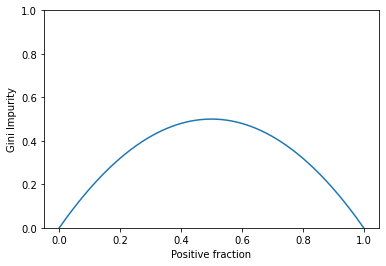

In [1]:
import matplotlib.pyplot as plt
import numpy as np

pos_fraction = np.linspace(0.00, 1.00, 1000)

gini = 1 - pos_fraction**2 - (1-pos_fraction)**2
plt.plot(pos_fraction, gini)
plt.ylim(0, 1)
plt.xlabel('Positive fraction')
plt.ylabel('Gini Impurity')
plt.show()

In [2]:
def gini_impurity(labels):
  # When the set is empty, it is also pure
  if not labels:
    return 0
  # Count the occurrences of each label
  counts = np.unique(labels, return_counts=True)[1]
  fractions = counts / float(len(labels))
  return 1 - np.sum(fractions ** 2)

In [3]:
print(f"{gini_impurity([1, 1, 0, 1, 0]):.4f}")

0.4800


In [4]:
print(f"{gini_impurity([1, 1, 0, 1, 0, 0]):.4f}")

0.5000


In [5]:
print(f"{gini_impurity([1, 1, 1, 1]):.4f}")

0.0000


Entropy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log2
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


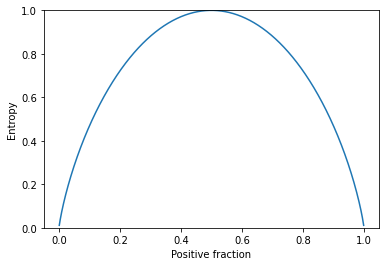

In [6]:
pos_fraction = np.linspace(0.00, 1.00, 1000)
ent = -(pos_fraction * np.log2(pos_fraction) + (1 - pos_fraction) * np.log2(1 - pos_fraction))

plt.plot(pos_fraction, ent)
plt.xlabel('Positive fraction')
plt.ylabel('Entropy')
plt.ylim(0, 1)
plt.show()

In [7]:
def entropy(labels: list):
  if not labels:
    return 0
  counts = np.unique(labels, return_counts=True)[1]
  fractions = counts / float(len(labels))
  return -np.sum(fractions * np.log2(fractions))

In [8]:
print(f"{entropy([1, 1, 0, 1, 0]):.4f}")
print(f"{entropy([1, 1, 0, 1, 0, 0]):.4f}")
print(f"{entropy([1, 1, 1, 1]):.4f}")

0.9710
1.0000
-0.0000


In [9]:
criterion_function = {'gini': gini_impurity, 'entropy': entropy}

def weighted_impurity(groups, criterion = 'gini'):
  """
  Calculate weighted impurity of children after a split
  Args:
    groups (list of children, and a child consists a list of class labels)
    criterion (metric to measure the quality of a split, 'gini' for Gini impurity or 'entropy' for information Gain)
  Returns:
    float, weighted impurity
  """
  total = sum(len(group) for group in groups)
  weighted_sum = 0.0
  for group in groups:
    weighted_sum += len(group) / float(total) * criterion_function[criterion](group)
  return weighted_sum

In [10]:
child_1 = [[1, 0, 1], [0, 1]]
child_2 = [[1, 1], [0, 0, 1]]

In [11]:
print('Entropy of #1 split: {:.4f}'.format(weighted_impurity(child_1, 'entropy')))

Entropy of #1 split: 0.9510


In [12]:
print('Entropy of #1 split: {:.4f}'.format(weighted_impurity(child_2, 'entropy')))

Entropy of #1 split: 0.5510


In [13]:
print('Gini of #1 split: {:.4f}'.format(weighted_impurity(child_1, 'gini')))

Gini of #1 split: 0.4667


In [14]:
print('Gini of #1 split: {:.4f}'.format(weighted_impurity(child_2)))

Gini of #1 split: 0.2667


In [16]:
import pandas as pd

data = pd.read_csv('/content/drive/My Drive/Machine Learning/ctr-20000.csv')
data.columns

Index(['id', 'click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [17]:
data = data.drop(['id', 'hour', 'device_ip', 'device_id'], axis=1)
data

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,44956a24,1,2,15706,320,50,1722,0,35,-1,79
1,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,711ee120,1,0,15704,320,50,1722,0,35,100084,79
2,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
3,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,6332421a,1,0,15706,320,50,1722,0,35,100084,79
4,0,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,779d90c2,1,0,18993,320,50,2161,0,35,-1,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,1005,0,85f751fd,c4e18dd6,50e219e0,a4869716,2347f47a,d1327cf5,cdfde03b,1,2,463,320,50,122,3,1319,100165,15
19996,0,1005,1,0a742914,510bd839,f028772b,ecad2386,7801e8d9,07d7df22,1f0bc64f,1,0,17914,320,50,2043,2,39,100084,32
19997,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,aaffed8f,1,0,15705,320,50,1722,0,35,-1,79
19998,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,06fbfd42,1,0,15705,320,50,1722,0,35,-1,79


In [ ]:
from sklearn.feature_extraction import DictVectorizer

data_X = data.loc[ :, data.columns != 'click'].astype('str')
data_Y = data.loc[ :, data.columns == 'click'].astype('int').values.ravel()

train_X, test_X = data_X[0:15000], data_X[15000:]
train_Y, test_Y = data_Y[0:15000], data_Y[15000:]

dict_one_hot_encoder = DictVectorizer(sparse = False)
onehot_train_X = dict_one_hot_encoder.fit_transform(train_X.to_dict('records'))
onehot_test_X = dict_one_hot_encoder.transform(test_X.to_dict('records'))

print(train_X.shape)
print(onehot_train_X.shape)

(15000, 19)
(15000, 3244)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [3, 10, None]}
decision_tree = DecisionTreeClassifier(criterion = 'gini',
                                       min_samples_split = 30)
grid_search = GridSearchCV(decision_tree, parameters,
                           n_jobs = -1, cv = 3, scoring = 'roc_auc')
grid_search.fit(onehot_train_X, train_Y)
grid_search.best_params_

{'max_depth': 10}

In [ ]:
decision_tree_best = grid_search.best_estimator_
pos_prob = decision_tree_best.predict_proba(onehot_test_X)[:, 1]

from sklearn.metrics import roc_auc_score
print(f"The ROC AUC on testing set is: {roc_auc_score(test_Y, pos_prob):.3f}")

The ROC AUC on testing set is: 0.688


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_depth': [3, 10, None]}

random_forest = RandomForestClassifier(n_estimators = 100,
                                       criterion = 'gini', min_samples_split = 30, n_jobs = -1)
grid_search = GridSearchCV(random_forest, parameters,
                           n_jobs = -1, cv = 3, scoring = 'roc_auc')
grid_search.fit(onehot_train_X, train_Y)
grid_search.best_params_

{'max_depth': None}

In [ ]:
random_forest_best = grid_search.best_estimator_
pos_prob = random_forest_best.predict_proba(onehot_test_X)[:, 1]
print("The ROC AUC on testing set is : {:.3f}"\
      .format(roc_auc_score(test_Y, pos_prob)))

The ROC AUC on testing set is : 0.706


In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

decision_tree = DecisionTreeClassifier(criterion = 'gini', min_samples_split=30, max_depth=3)

clf = AdaBoostClassifier(base_estimator=decision_tree,
                         n_estimators = 50, learning_rate = 1)
clf.fit(onehot_train_X, train_Y)

pos_prob = clf.predict_proba(onehot_test_X)[:, 1]

print("The ROC AUC on testing set is : {:.3f}"\
      .format(roc_auc_score(test_Y, pos_prob)))

The ROC AUC on testing set is : 0.699


In [ ]:
# 많은 머신러닝 문제에서 XGBoost나 LightGBM이
# 딥러닝 기반 모델보다 더 좋은 성능을 보이고 있음